# Runtime Experiment

Notes for the reader:

1. The exact y-values for these plots can be recreated using Apple 2.3 GHz 8-Core Intel Core i9 with 32 GB 2400 MHz DDR4. When other hardware is used, the specific y-values for each plot may change, but we expect qualitative features of the plots in this notebook to remain true. In particular, while the y-values for each plot may be lower if a faster computer is used -- or that the y-values for each plot may be higher if a slower computer is used -- the ordering of the curves from left to right is expected to remain consistent.

2. When running the cells of this notebook to generate the data for the plots, the printed cells will note that an exception was caught during the process. This is expected behavior of our notebook, as this exception is raised as when running Scipy's simplex solver (which we catalog as part of the output). 


In [1]:
from pets_utilities import *
from plotting_utilities import *

from scipy.optimize import curve_fit

from seaborn import heatmap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
methods_runtime = [create_simulate_run_from_constructor( max_heuristic_constructor) ,
                   create_simulate_run_from_constructor( interior_method_fixed_point_constructor ), 
                   create_simulate_run_from_constructor( simplex_fixed_point_constructor) ,
                   create_simulate_run_from_constructor( unfixed_baseline_constructor),
                   simulate_run_truncated_geom
             ]

In [3]:
def runtime_experiment(max_n, replications, hist_function, simulate_run_functions, total_epsilon = np.log(2), fraction_epsilon_for_laplace = 0.5, print_updates = True, timeout = 2, n_step = 4):
    results = None
    laplace_epsilon = total_epsilon * fraction_epsilon_for_laplace
    counting_epsilon = total_epsilon - laplace_epsilon
    
    for simulate_run_function in simulate_run_functions:
        print("Measuring runtime of", simulate_run_function.__name__,":" , end= " ")
        consecutive_timeouts = 0
        for n in range(2, max_n+1, n_step):
            if print_updates:
                print(f'{n}', end=" ")
            start_time = time.time()
            try:
                sim_results = repeat_simulate_run(replications = replications, simulate_run_function = simulate_run_function, emp_hist = hist_function(n), laplace_epsilon = laplace_epsilon, counting_epsilon = counting_epsilon)
                sim_results['n'] = n
                if results is None:
                    results = pd.DataFrame(sim_results, index = [0])
                else:
                    results.loc[len(results)] = sim_results
            except:
                print("caught exception while calling repeat_simulate_run")
            if time.time()-start_time > timeout * replications:
                break
        if print_updates:
            print('')
    return results


In [4]:
labels_runtime = {
    'sandwich_heuristic_constructor': 'Heuristic (Sandwich)',
    'max_heuristic_constructor': 'Heuristic (Max Selector)',
    'min_heuristic_constructor': 'Heuristic (Min Selector)',
    'interior_method_fixed_point_constructor': 'Interior Point',
    'Unconstrained Optimum': 'Unconstrained Optimum',
    'unfixed_baseline_constructor': '2-Stage Unfixed Optimum',
    'truncated_geom': 'Trun Geom / Staircase',
    'discrete_gaussian': 'Discrete Gaussian',
    'simplex_fixed_point_constructor': 'Simplex',
}


### Runtime Plot (Crime) -- Figure 7 in Paper

In [5]:
np.random.seed(42)
timeout = 2

crime_time_res  = runtime_experiment(max_n = 100, 
                   replications = 4, 
                   hist_function = crime_hist, 
                   simulate_run_functions = methods_runtime, 
                   total_epsilon = np.log(2), 
                   fraction_epsilon_for_laplace = 0.5, 
                   print_updates = True, 
                   timeout = timeout)

Measuring runtime of simulate_run : 2 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 
22 26 30 34 38 42 46 50 54 te_run : 2 6 10 14 18 
10 14 18  runtime of simulate_run : 2 6 
38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98  22 26 30 34 
34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 2 6 10 14 18 22 26 30 


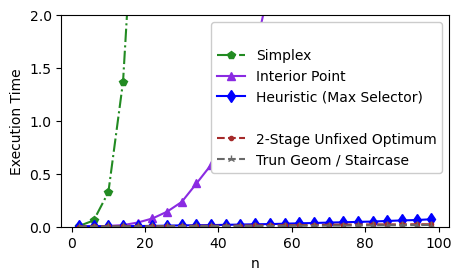

In [6]:
fp_methods = ['simplex_fixed_point_constructor',  'interior_method_fixed_point_constructor', 'max_heuristic_constructor']
uf_methods = ['unfixed_baseline_constructor', 'truncated_geom']

fig, ax = plt.subplots(figsize=(5, 2.75))

ax.plot([], [], ' ', label=" ") ## For spacing

for method in fp_methods:
    temp = crime_time_res[crime_time_res.method == method]
    ax.plot(temp['n'], temp['runtime'], label = labels_runtime[method], marker = markers[method], linestyle = linestyles[method], color = colors[method])

ax.plot([], [], ' ', label=" ") ## For spacing 

for method in uf_methods:
    temp = crime_time_res[crime_time_res.method == method]
    ax.plot(temp['n'], temp['runtime'], label = labels_runtime[method], marker = markers[method], linestyle = linestyles[method], color = colors[method])


plt.ylim((0,timeout))    
plt.xlabel("n")
plt.ylabel("Execution Time")
plt.legend(loc='upper right', framealpha=1.0)

plt.show()

### Runtime Plot (Binomial)

In [15]:
np.random.seed(42)
timeout = 2

binom_time_res = runtime_experiment(max_n = 100, 
                   replications = 2, 
                   hist_function = binomial_hist, 
                   simulate_run_functions = methods_runtime, 
                   total_epsilon = np.log(2), 
                   fraction_epsilon_for_laplace = 0.5, 
                   print_updates = True, 
                   timeout = timeout)

Measuring runtime of simulate_run : 2 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 
26 30 34 38 42 46 50 54 ulate_run : 2 6 10 14 18 22 
14 18 caught exception while calling repeat_simulate_run
caught exception while calling repeat_simulate_run

50 54 58 62 66 70 74 78 82 86 90 94 98  10 14 18 22 26 30 34 38 42 46 
10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 


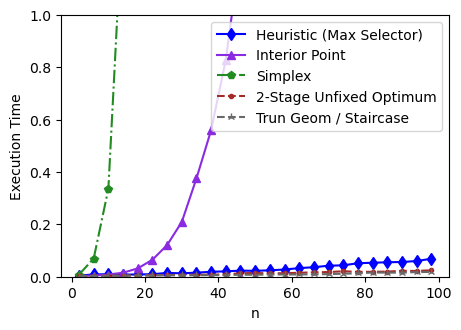

In [16]:
methods = binom_time_res.method.unique().tolist()
fig, ax = plt.subplots(figsize=(5, 3.4))

for method in methods:
    temp = binom_time_res[binom_time_res.method == method]
    ax.plot(temp['n'], temp['runtime'], label = labels_runtime[method], marker = markers[method], linestyle = linestyles[method], color = colors[method])

plt.ylim((0,timeout / 2))    
plt.xlabel("n")
plt.ylabel("Execution Time")
plt.legend(loc='upper right')

plt.show()

### Runtime Plot (Schools)

In [12]:
np.random.seed(42)
timeout_bound = 2

schools_time_res  = runtime_experiment(max_n = 100, 
                   replications = 2, 
                   hist_function = schools_hist, 
                   simulate_run_functions = methods_runtime, 
                   total_epsilon = np.log(2), 
                   fraction_epsilon_for_laplace = 0.5, 
                   print_updates = True, 
                   timeout = timeout)

Measuring runtime of simulate_run : 2 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 
14 18 22 26 30 34 38 42 46 50 54  : 2 6 10 
10 14 18 caught exception while calling repeat_simulate_run
caught exception while calling repeat_simulate_run

14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 
6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94 98 


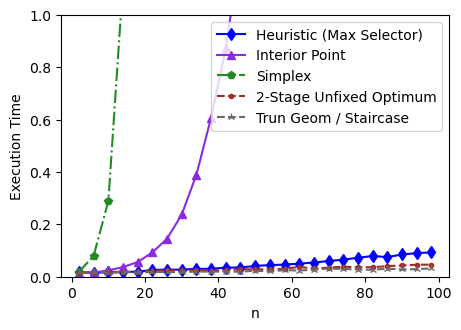

In [14]:
methods = schools_time_res.method.unique().tolist()
fig, ax = plt.subplots(figsize=(5, 3.4))

for method in methods:
    temp = schools_time_res[schools_time_res.method == method]
    ax.plot(temp['n'], temp['runtime'], label = labels_runtime[method], marker = markers[method], linestyle = linestyles[method], color = colors[method])

plt.ylim((0,timeout / 2))    
plt.xlabel("n")
plt.ylabel("Execution Time")
plt.legend(loc='upper right')

plt.show()